In [1]:
%reload_ext autoreload
%autoreload 2

import notebook_setup
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime, timezone, timedelta
from sklearn.preprocessing import MinMaxScaler
from tslearn.utils import to_time_series
from tslearn.metrics import dtw
from tqdm.auto import tqdm

from bdx import get_trend
from utils import get_credentials

/home/ahmedi/miniconda3/envs/esb/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
cst = timezone(offset=-timedelta(hours=6))
cdt = timezone(offset=-timedelta(hours=5))

datadir = os.path.join(os.environ.get('DATADIR'), 'EngineeringScienceBuilding')
username, password = get_credentials()
trend = '3481'      # python setpoint trend
ch2trend = '2841'  # chiller 2 detailed trend
ch1trend = '2422'  # chiller 1 detailed trend
simcols = ['TempAmbient', 'TempWetBulb', 'Tonnage']

ch1start, ch1end = datetime(2021,9,16,0,0, tzinfo=cdt), datetime(2021,10,1,0,0, tzinfo=cdt)
ch2start, ch2end = datetime(2021,4,19, tzinfo=cdt), datetime(2021,5,3, tzinfo=cdt)
oldstart, oldend = datetime(2020,3,1, tzinfo=cst), datetime(2021,3,8, tzinfo=cst)

## Getting historical and benchmark data

Using Dynamic Time Warping to compare a day under controller vs a similar day under old control. Ambient and Wetbulb temperature time series are used to measure similarity.

In [3]:
chiller = 1
if chiller == 1 or chiller == '1v2':
    start, end, chtrend = ch1start, ch1end, ch1trend
    refstart, refend, reftrend = (oldstart, oldend, ch1trend) if chiller == 1 else (ch2start, ch2end, ch2trend)
elif chiller == 2 or chiller == '2v1':
    start, end, chtrend = ch2start, ch2end, ch2trend
    refstart, refend, reftrend = (oldstart, oldend, ch2trend) if chiller == 2 else (ch1start, ch1end, ch1trend)

In [4]:
# Download data under controller script used for comparison
data_stpt = get_trend(trend, username, password,
                 start=start,
                 end=end)
data_stpt = data_stpt[['CDWTPythonSetpt', 'JCI Cooling_Tower_Water_Setpoint']]
data_ch = get_trend(chtrend, username, password,
                 start=start,
                 end=end)

valid = (data_ch['RunChi']==True) & (data_ch['PowChi'] > 0) & (data_ch['Tonnage'] > 0)
data_ch = data_ch[valid]
data_ch.index = data_ch.index.tz_convert(cdt)
data_stpt = data_stpt[valid]
data_stpt.index = data_stpt.index.tz_convert(cdt)

In [ ]:
# Download reference setpoint data for comparison
ref_stpt = get_trend(trend, username, password,
                    start=refstart,
                    end=refend)
ref_stpt = ref_stpt[['CDWTPythonSetpt', 'JCI Cooling_Tower_Water_Setpoint']]

# Reference chiller data for comparison
ref_ch = get_trend(reftrend, username, password,
                   start=refstart,
                   end=refend)

ref_stpt = ref_stpt[(ref_ch['RunChi']==True) & (ref_ch['PowChi'] > 0)]
ref_ch = ref_ch.loc[(ref_ch['RunChi']==True) & (ref_ch['PowChi'] > 0)]

# Save data to disk for later use
ref_stpt.to_csv(os.path.join(datadir, '%s_Chiller%s_setpoint_eval.csv' % (trend, str(chiller))))
ref_ch.to_csv(os.path.join(datadir, '%s_Chiller%s_eval.csv' % (chtrend, str(chiller))))
ref_stpt.index = ref_stpt.index.tz_convert(cdt)
ref_ch.index = ref_ch.index.tz_convert(cdt)

In [5]:
# Or Load reference data from disk
ref_stpt = pd.read_csv(os.path.join(datadir, '%s_Chiller%s_setpoint_eval.csv' % (trend, str(chiller))), index_col='time', parse_dates=True)
ref_ch = pd.read_csv(os.path.join(datadir, '%s_Chiller%s_eval.csv' % (chtrend, str(chiller))), index_col='time', parse_dates=True)
ref_stpt.index = ref_stpt.index.tz_convert(cdt)
ref_ch.index = ref_ch.index.tz_convert(cdt)

In [ ]:
ref_ch.head()

## Processing data

In [6]:
starttime = data_ch.index[0].timetz()  # start TIME of controller
endtime = data_ch.index[-1].timetz()   # end TIME of controller

# Chiller agnostic referencing for analysis
refdata = ref_ch # reference data 
data = data_ch  # controller data

In [7]:
# Find most similar time period in reference data
# Find the start time in reference data which is the same as the controller data:
refstart = None
refend = refdata.index[-1]
for t in refdata.index:
    if t.timetz() == starttime:
        refstart = t
        break

scaler = MinMaxScaler()
scaler.fit(refdata[simcols])
refsegments = []
similarities = []
span = pd.Timedelta(days=1)
# Run a window of size `span` by shifting it by a freq=1D
# to find similarities between segments using dynamic time warping
date_ticks = pd.date_range(data.index[0], data.index[-1], freq='1D')
rdate_ticks = pd.date_range(refstart, refend, freq='1D')
similarities = np.zeros((len(date_ticks), len(rdate_ticks))) + np.inf
for i, date in enumerate(tqdm(date_ticks, leave=False, desc='Data spans')):
    segment = data.loc[date:date + span]
    for j, rdate in enumerate(tqdm(rdate_ticks, leave=False, desc='Reference spans')):
        rsegment = refdata.loc[rdate:rdate + span]
        refsegments.append(rsegment)
        if len(rsegment)==0: continue
        if len(segment)==0: continue
        similarities[i, j] = dtw(
                to_time_series(scaler.transform(rsegment[simcols])),
                to_time_series(scaler.transform(segment[simcols])))

# Rank reference segments by similarity against data segments
ranked = np.argsort(similarities, axis=1)
mostsim, dates = [], []
for row in ranked:
    for idx in row:
        if refsegments[idx]['PowChi'].mean() > 0:
            mostsim.append(refsegments[idx])
            dates.append(refsegments[idx].index.to_series())
            break
# Create a dataframe of the most similar reference segments for each segment in data
mostsim = pd.concat(mostsim, ignore_index=True)
mostsim['dates'] = pd.concat(dates, ignore_index=True)

Data spans:   0%|          | 0/15 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

Reference spans:   0%|          | 0/282 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(7,12))
plt.subplot(2,1,1)
_, xedges, yedges, _ = plt.hist2d(mostsim[simcols[0]], mostsim[simcols[1]], density=True)
plt.title('Most similar period conditions')
plt.xlabel('Ambient')
plt.ylabel('Wet bulb')
plt.colorbar()
plt.subplot(2,1,2)
plt.hist2d(data[simcols[0]], data[simcols[1]], bins=[xedges, yedges], density=True)
plt.title('Controller conditions')
plt.xlabel('Ambient')
plt.ylabel('Wet bulb')
plt.colorbar()

## Comparison plots of benchmarks

In [ ]:
# Plot
fig, axes = plt.subplots(7, 1, figsize=(8,42), facecolor='white')
axes = axes.ravel()
# fig.suptitle('Benchmark')

mostsim[simcols[:2]].plot(ax=axes[0])
# ref_stpt[['JCI Cooling_Tower_Water_Setpoint']].plot(ax=axes[0], ls=':')
# ref_stpt[['CDWTPythonSetpt']].plot(ax=axes[0], ls=':')
axes[0].set_ylim(20,80)
axes[0].set_ylabel('Temperature /F')
axes[0].set_title('Ambient Conditions, Temp: %.1f+/-%.1fF, Wetbulb: %.1f+/-%.1fF' % \
                  (mostsim['TempAmbient'].mean(), mostsim['TempAmbient'].std(),
                   mostsim['TempWetBulb'].mean(), mostsim['TempWetBulb'].std()))

ctefficiency = (mostsim['TempCondOut'] - mostsim['TempCondIn']) / \
               (mostsim['TempCondOut'] - mostsim['TempWetBulb'])
ctefficiency.plot(ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Cooling Tower Efficiency %.2f +/- %.2f' % (ctefficiency.mean(), ctefficiency.std()))

mostsim[['PowChi', 'Tonnage']].plot(ax=axes[2])
kw = mostsim['PowChi'] / mostsim['Tonnage']
axes[2].set_title('Average chiller efficiency %.2f +/- %.2fkW/Ton' % (kw.mean(), kw.std()))
axes[2].set_ylabel('Power /kW')
axes[2].set_ylim(0, 500)

mostsim['PerFreqFanA'].plot(ax=axes[3])
axes[3].set_ylabel('Percentage frequency /%')
axes[3].set_title('Fan frequency')
axes[3].set_ylim(0, 105)

mostsim[['TempCondIn', 'TempCondOut']].plot(ax=axes[4])
# ref_stpt[['JCI Cooling_Tower_Water_Setpoint']].plot(ax=axes[4], ls=':')
axes[4].set_ylim(50, 90)
deltat = (mostsim['TempCondOut'] - mostsim['TempCondIn'])
axes[4].set_ylabel('Temperature /F')
axes[4].set_title('Condenser Temps, Avg change %.2f +/- %.2fF' % (deltat.mean(), deltat.std()))

scatterdf = pd.DataFrame({
    'Cooling Tower Efficiency': ctefficiency,
    'Chiller load /%': mostsim['Tonnage'] * 100/800,
})
corr = scatterdf.corr().values[0,1]
scatterdf.plot.scatter('Cooling Tower Efficiency', 'Chiller load /%', ax=axes[5])
axes[5].set_title('Efficiency vs Load, correlation %.2f' % corr)
axes[5].set_xlim(0, 1)
axes[5].set_ylim(0, 100)

scatterdf = pd.DataFrame({
    'Chiller load /%': mostsim['Tonnage'] * 100/800,
    'kw/Ton': mostsim['PowChi'] / mostsim['Tonnage'],
    'Returning Water Temp /F': mostsim['TempCondIn']
})
scatterdf.plot.scatter('Chiller load /%', 'kw/Ton', c='Returning Water Temp /F',
                       colormap='coolwarm', vmin=50, vmax=90, ax=axes[6])
mean, std = scatterdf.mean().values, scatterdf.std().values
axes[6].set_title('Average kw/Ton %.2f+/-%.2f, Chiller load %.2f+/-%.2f, Ret. temp %.2f+/-%.2f)' % \
                  (mean[1], std[1], mean[0], std[0], mean[2], std[2]))
axes[6].errorbar(mean[0], mean[1], xerr=std[0], yerr=std[1])
axes[6].set_xlim(0, 100)
axes[6].set_ylim(0, 1)


for ax in axes:
    ax.set_facecolor('whitesmoke')
    ax.grid(True, 'both')
plt.tight_layout()

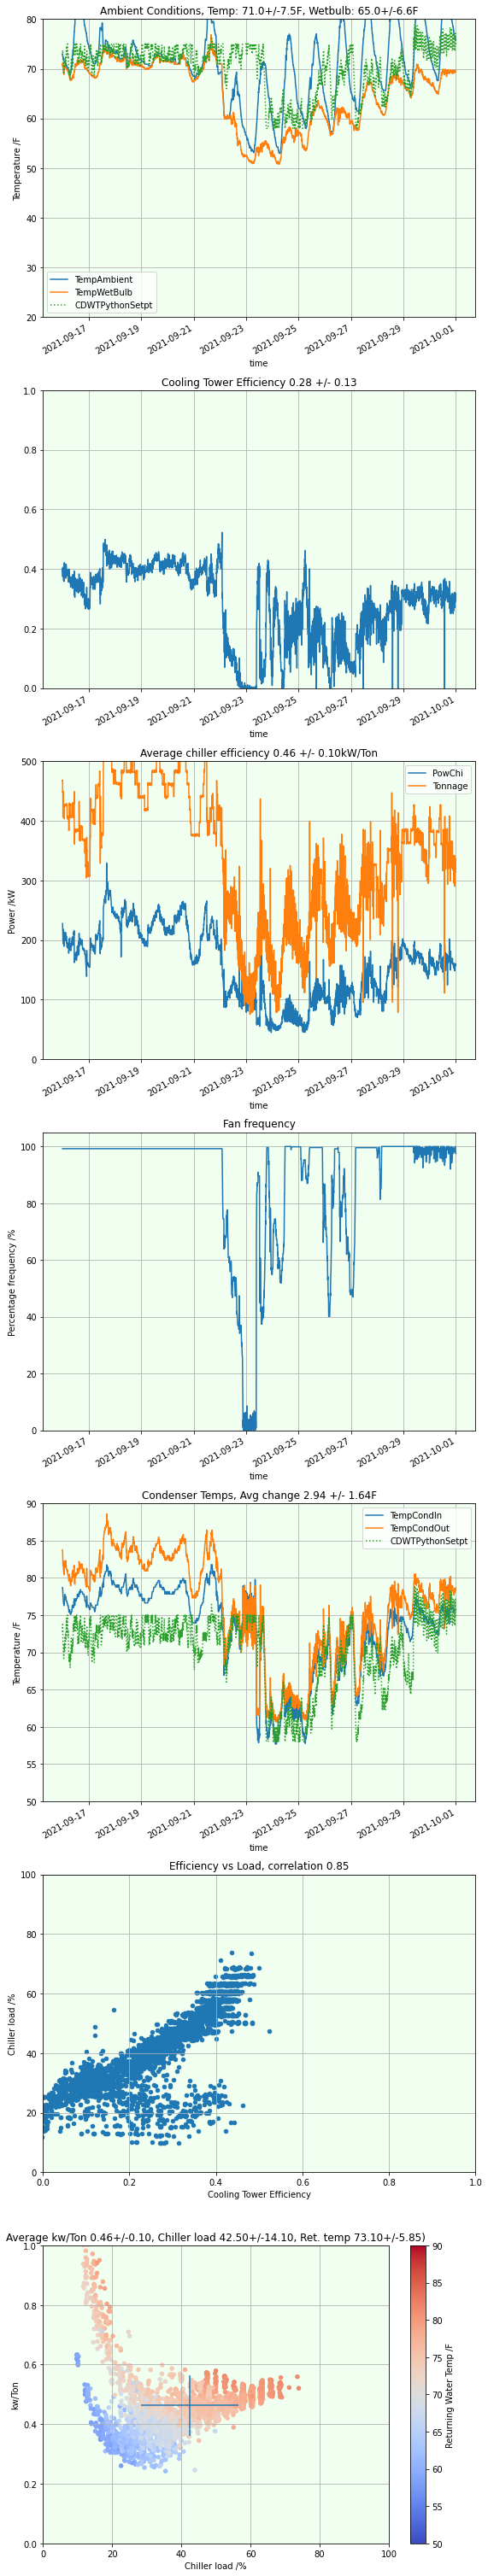

In [8]:
# Plot
fig, axes = plt.subplots(7, 1, figsize=(8,42), facecolor='white')
axes = axes.ravel()
# fig.suptitle('Controller')

data[simcols[:2]].plot(ax=axes[0])
data_stpt[['CDWTPythonSetpt']].plot(ax=axes[0], ls=':')
axes[0].set_ylim(20,80)
axes[0].set_ylabel('Temperature /F')
axes[0].set_title('Ambient Conditions, Temp: %.1f+/-%.1fF, Wetbulb: %.1f+/-%.1fF' % \
                  (data['TempAmbient'].mean(), data['TempAmbient'].std(),
                   data['TempWetBulb'].mean(), data['TempWetBulb'].std()))

ctefficiency = (data['TempCondOut'] - data['TempCondIn']) / \
               (data['TempCondOut'] - data['TempWetBulb'])
ctefficiency.plot(ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Cooling Tower Efficiency %.2f +/- %.2f' % (ctefficiency.mean(), ctefficiency.std()))

data[['PowChi', 'Tonnage']].plot(ax=axes[2])
kw = data['PowChi'] / data['Tonnage']
axes[2].set_title('Average chiller efficiency %.2f +/- %.2fkW/Ton' % (kw.mean(), kw.std()))
axes[2].set_ylabel('Power /kW')
axes[2].set_ylim(0, 500)

data['PerFreqFanA'].plot(ax=axes[3])
axes[3].set_ylabel('Percentage frequency /%')
axes[3].set_title('Fan frequency')
axes[3].set_ylim(0, 105)

data[['TempCondIn', 'TempCondOut']].plot(ax=axes[4])
data_stpt[['CDWTPythonSetpt']].plot(ax=axes[4], ls=':')
axes[4].set_ylim(50, 90)
deltat = (data['TempCondOut'] - data['TempCondIn'])
axes[4].set_ylabel('Temperature /F')
axes[4].set_title('Condenser Temps, Avg change %.2f +/- %.2fF' % (deltat.mean(), deltat.std()))

scatterdf = pd.DataFrame({
    'Cooling Tower Efficiency': ctefficiency,
    'Chiller load /%': data['Tonnage'] * 100/800,
})
corr = scatterdf.corr().values[0,1]
scatterdf.plot.scatter('Cooling Tower Efficiency', 'Chiller load /%', ax=axes[5])
axes[5].set_title('Efficiency vs Load, correlation %.2f' % corr)
axes[5].set_xlim(0, 1)
axes[5].set_ylim(0, 100)

scatterdf = pd.DataFrame({
    'Chiller load /%': data['Tonnage'] * 100/800,
    'kw/Ton': data['PowChi'] / data['Tonnage'],
    'Returning Water Temp /F': data['TempCondIn']
})
scatterdf.plot.scatter('Chiller load /%', 'kw/Ton', c='Returning Water Temp /F',
                       colormap='coolwarm', vmin=50, vmax=90, ax=axes[6])
mean, std = scatterdf.mean().values, scatterdf.std().values
axes[6].set_title('Average kw/Ton %.2f+/-%.2f, Chiller load %.2f+/-%.2f, Ret. temp %.2f+/-%.2f)' % \
                  (mean[1], std[1], mean[0], std[0], mean[2], std[2]))
axes[6].errorbar(mean[0], mean[1], xerr=std[0], yerr=std[1])
axes[6].set_xlim(0, 100)
axes[6].set_ylim(0, 1)


for ax in axes:
    ax.set_facecolor('honeydew')
    ax.grid(True, 'both')
plt.tight_layout()